### Instructions:
* Download the cifar_net.pth model and set the PATH variable in this notebook to the appropriate path of the cifar_net.pth file.
* Execute this notebook to perform L1 Structured Pruning, using PyTorch's built-in functionality, on a pretrained CNN (cifar_net.pth), trained for classification on the cifar10 dataset.
* The pruned model is tested for its accuracy (no. of correct classifications/total no. of classifications) on the test set of cifar10.
* The unpruned model has a test accuracy of 79.67%.

> CIFAR10 dataset has 10 classes - ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

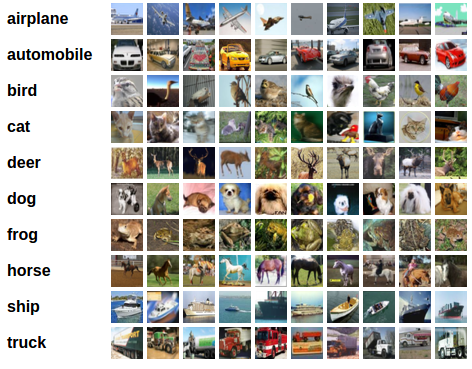

# Selecting device

In [47]:
import torch 

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# Loading and normalizing images using TorchVision


In [48]:
import torchvision
import torchvision.transforms as transforms

In [49]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Displaying some images

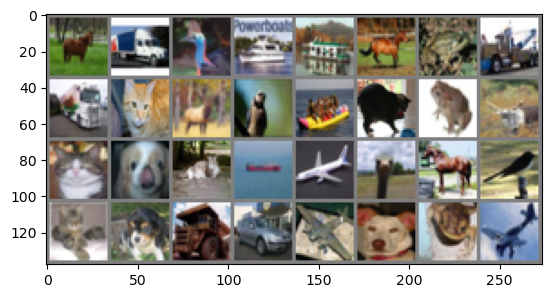

horse truck  bird  ship


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Defining a Convolutional Neural Network

In [51]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 3).to(device)
        self.pool = nn.MaxPool2d(2, 2).to(device)
        self.bn1 = nn.BatchNorm2d(256).to(device)
        self.conv2 = nn.Conv2d(256, 512, 3).to(device)
        self.bn2 = nn.BatchNorm2d(512).to(device)
        self.conv3 = nn.Conv2d(512, 1024, 3).to(device)
        self.bn3 = nn.BatchNorm2d(1024).to(device)
        self.fc1 = nn.Linear(1024 * 2 * 2, 2048).to(device)
        self.fc2 = nn.Linear(2048, 512).to(device)
        self.fc3 = nn.Linear(512, 10).to(device)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)).to(device))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)).to(device))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)).to(device))
        x = self.bn3(x)
        x = x.view(-1, 1024 * 2 * 2)
        x = F.relu(self.fc1(x)).to(device)
        x = F.relu(self.fc2(x)).to(device)
        x = self.fc3(x)
        x = nn.functional.log_softmax(x, dim=1).to(device)
        return x


net = Net()

In [52]:
total = 0
print('Trainable parameters:')
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total)

Trainable parameters:
conv1.weight 	 6912
conv1.bias 	 256
bn1.weight 	 256
bn1.bias 	 256
conv2.weight 	 1179648
conv2.bias 	 512
bn2.weight 	 512
bn2.bias 	 512
conv3.weight 	 4718592
conv3.bias 	 1024
bn3.weight 	 1024
bn3.bias 	 1024
fc1.weight 	 8388608
fc1.bias 	 2048
fc2.weight 	 1048576
fc2.bias 	 512
fc3.weight 	 5120
fc3.bias 	 10

Total 	 15355402


# Now we will load our model

In [53]:
PATH = './cifar_net.pth'

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Pruning the model

In [54]:
import torch.nn.utils.prune as prune

## Inspecting the conv1 layer

In [55]:
module = net.conv1

for name, param in module.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())

weight 	 6912
bias 	 256


Let's check the weight parameter of net's conv1 layer:

In [56]:
print(module.weight)

Parameter containing:
tensor([[[[ 0.1850, -0.0669, -0.0983],
          [ 0.0360, -0.1107, -0.0511],
          [-0.0734,  0.0119, -0.0207]],

         [[-0.0618, -0.0153, -0.0966],
          [ 0.0206, -0.2910, -0.0890],
          [ 0.2411, -0.1336, -0.1841]],

         [[-0.1148, -0.0244,  0.1733],
          [ 0.1523, -0.1550, -0.0779],
          [-0.0888,  0.0625, -0.0759]]],


        [[[ 0.0905, -0.0178,  0.0009],
          [-0.1611, -0.0872, -0.1800],
          [-0.0992, -0.1417, -0.0783]],

         [[ 0.0259, -0.0528,  0.1320],
          [-0.0243,  0.0162,  0.0123],
          [ 0.1275, -0.0202,  0.1674]],

         [[ 0.1651,  0.0737, -0.1396],
          [ 0.0068,  0.0702, -0.1284],
          [-0.0139,  0.1145, -0.1455]]],


        [[[-0.0520, -0.1696,  0.0760],
          [-0.0365,  0.1644,  0.1591],
          [-0.1428, -0.0450, -0.0049]],

         [[-0.0379,  0.1427, -0.1878],
          [-0.0352,  0.1795, -0.0176],
          [-0.0326,  0.0962, -0.1056]],

         [[-0.0938,  0

## Ln Structured Pruning

**Pruning 40% of the channels based on the channels' L1 norm**

In [57]:
module = net.conv1
prune.ln_structured(module, name="weight", amount=0.4, n=1, dim=0)

Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))

In [58]:
print(module._forward_pre_hooks)

OrderedDict([(39, <torch.nn.utils.prune.LnStructured object at 0x7f02243c7640>)])


In [59]:
total_params = 0
pruned_params = 0

flag = 0
for name, module in net.named_modules():
    if flag == 0:
        flag = 1 
        continue
    try:
        total_params += module.weight.nelement()
        total_params += module.bias.nelement()
        
        pruned_params += torch.sum(module.weight == 0).item()
        pruned_params += torch.sum(module.bias == 0).item()
    except AttributeError:
        pass
    
print("")
print("Parameters pruned: "+str(pruned_params))
print("Remaining parameters: "+str(total_params - pruned_params))
print("Total parameters: "+str(total_params))


Parameters pruned: 2754
Remaining parameters: 15352648
Total parameters: 15355402


Let's now check the weight parameter of net's conv1 layer after pruning. We can see that weights of some of the filters have been set to zero (i.e. pruned):

In [60]:
module = net.conv1
print(module.weight)

tensor([[[[ 0.1850, -0.0669, -0.0983],
          [ 0.0360, -0.1107, -0.0511],
          [-0.0734,  0.0119, -0.0207]],

         [[-0.0618, -0.0153, -0.0966],
          [ 0.0206, -0.2910, -0.0890],
          [ 0.2411, -0.1336, -0.1841]],

         [[-0.1148, -0.0244,  0.1733],
          [ 0.1523, -0.1550, -0.0779],
          [-0.0888,  0.0625, -0.0759]]],


        [[[ 0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000]],

         [[ 0.0000, -0.0000,  0.0000],
          [-0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.0000,  0.0000]],

         [[ 0.0000,  0.0000, -0.0000],
          [ 0.0000,  0.0000, -0.0000],
          [-0.0000,  0.0000, -0.0000]]],


        [[[-0.0520, -0.1696,  0.0760],
          [-0.0365,  0.1644,  0.1591],
          [-0.1428, -0.0450, -0.0049]],

         [[-0.0379,  0.1427, -0.1878],
          [-0.0352,  0.1795, -0.0176],
          [-0.0326,  0.0962, -0.1056]],

         [[-0.0938,  0.1761,  0.0117],
     

We would also have a weight mask now. Internally, this weight mask is multiplied element-wise with the original weight parameter to obtain the final (pruned) weight parameter of the module:

In [61]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        ...,


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

# Let's test the accuracy of the model

In [62]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 75 %


**Let's see which classes performed well individually**

In [63]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82 %
Accuracy of   car : 78 %
Accuracy of  bird : 65 %
Accuracy of   cat : 46 %
Accuracy of  deer : 78 %
Accuracy of   dog : 67 %
Accuracy of  frog : 92 %
Accuracy of horse : 71 %
Accuracy of  ship : 87 %
Accuracy of truck : 79 %
